<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import pickle

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# metrics
from sklearn import metrics

# Boost models
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

import time
import warnings
warnings.simplefilter('ignore', FutureWarning)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
df_test = pd.read_csv('../data/processed/df_test.csv')
df_test.head()

,rain,temp,rhum,wdsp,date,hour,day,month,year,count,...,working_day,season,peak,timesofday,rainfall_intensity,wind_bft,wind_speed_group,temp_r,temp_bin,rhum_bin
0,0.0,-0.2,96,6,2022-03-01,0,1,3,2022,0,...,True,Winter,False,Night,no rain,2,Calm / Light Breeze,0,0.0,4.0
1,0.0,-1.8,93,4,2022-03-01,1,1,3,2022,1,...,True,Winter,False,Night,no rain,2,Calm / Light Breeze,-2,0.0,4.0
2,0.0,-1.5,93,5,2022-03-01,2,1,3,2022,0,...,True,Winter,False,Night,no rain,2,Calm / Light Breeze,-2,0.0,4.0
3,0.0,-2.6,93,5,2022-03-01,3,1,3,2022,3,...,True,Winter,False,Night,no rain,2,Calm / Light Breeze,-3,0.0,4.0
4,0.0,-2.5,93,3,2022-03-01,4,1,3,2022,7,...,True,Winter,False,Night,no rain,2,Calm / Light Breeze,-3,0.0,4.0


In [3]:
df = df_test.copy()
X = df.drop(['count'], axis=1)
y = df.pop('count')
all_columns = list(X.columns)
X.shape

(1464, 22)

In [4]:
import category_encoders as ce

def preprocessor(predictors: list) -> ColumnTransformer:
    # Setting remainder='passthrough' will mean that all columns not specified in the list of “transformers” 
    #   will be passed through without transformation, instead of being dropped

    ##################### Categorical variables #####################
    all_cat_vars = ['timesofday','dayofweek','holiday','peak','hour','working_day','season','month']
    cat_vars = [categorical_var for categorical_var in all_cat_vars if categorical_var in predictors]

    # categorical variables
    cat_pipe = Pipeline([
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    cat_encoder = 'cat', cat_pipe, cat_vars

    ##################### Numerical variables #####################
    all_num_vars = ['rain', 'temp', 'rhum','wdsp','temp_r']
    num_vars = [numerical_var for numerical_var in all_num_vars if numerical_var in predictors]

    num_pipe = Pipeline([
        ('scaler', StandardScaler())
        # ('scaler', MinMaxScaler())
    ])

    num_enconder =  'num', num_pipe, num_vars

    ##################### Ordinal variables #####################
    all_ord_vars = ['wind_speed_group','rainfall_intensity']
    ord_vars = [ordinal_var for ordinal_var in all_ord_vars if ordinal_var in predictors]

    ordinal_cols_mapping = []
    if 'wind_speed_group' in predictors:
        ordinal_cols_mapping.append(
            {"col":"wind_speed_group",    
            "mapping": {
                'Calm / Light Breeze': 0, 
                'Breeze': 1, 
                'Moderate Breeze': 2, 
                'Strong Breeze / Near Gale': 3, 
                'Gale / Storm': 4
            }}
        )

    if 'rainfall_intensity' in predictors:
        ordinal_cols_mapping.append(
            {"col":"rainfall_intensity",    
            "mapping": {
                'no rain': 0, 
                'drizzle': 1, 
                'light rain': 2, 
                'moderate rain': 3, 
                'heavy rain': 4
            }}
        )

    # ordinal variables
    ord_pipe = Pipeline([
        ('ordinal', ce.OrdinalEncoder(mapping=ordinal_cols_mapping))
    ])

    ord_enconder =  'ordinal', ord_pipe, ord_vars
    
    #################################################################################
    
    orig_vars = [var for var in predictors if var not in cat_vars and var not in num_vars and var not in ord_vars]
    orig_enconder = 'pass_vars', 'passthrough', orig_vars
     # ['temp_bin','rhum_bin']
    # ord_pipe = 'passthrough'

    transformers_list = []
    transformers_list.append(cat_encoder) if cat_vars else None
    transformers_list.append(ord_enconder) if ord_vars else None
    transformers_list.append(num_enconder) if num_vars else None
    # transformers_list.append(orig_enconder) if orig_vars else None
    
    return ColumnTransformer(transformers=transformers_list, 
                             remainder='drop')

## Loading models

In [5]:
pipeline_xgboost = joblib.load('../models/xgb_pipeline.pkl')

In [7]:
xgb_model = xgb.XGBRegressor()
xgb_model.load_model("../models/XGBoost.json")

In [9]:
xgb_pipe = pickle.load(open("../models/xgb_pipeline.pkl", "rb"))

In [12]:
predicted = pd.Series(xgb_pipe.predict(X))

In [13]:
def round_up(x):
    '''
    Helper function to round away from zero
    '''
    from math import copysign
    return int(x + copysign(0.5, x))

### Normalized Root Mean Square Error (NRMSE)

$NRMSE = \frac{RSME}{y_{max} - y_{min}}$

In [43]:
# NRMSE (Normalized Root Mean Square Error)
def normalized_rsme(value, dataset) -> float:
    return value / max(dataset['count']) - min(dataset['count'])

In [48]:
rsme_score = metrics.mean_squared_error(y, predicted, squared=False)
normalized_rsme_score = normalized_rsme(rsme_score, df_test)

In [14]:
actual_predicted = {'Actual': y, 'Predicted': predicted}
new_df = pd.DataFrame(actual_predicted)
new_df["Period"] = pd.to_datetime(X.date) + pd.to_timedelta(X.hour, unit='h')
new_df.set_index('Period')


,Actual,Predicted
Period,,
2022-03-01 00:00:00,0,1.083633
2022-03-01 01:00:00,1,0.794334
2022-03-01 02:00:00,0,0.674126
2022-03-01 03:00:00,3,0.932812
2022-03-01 04:00:00,7,2.231707
...,...,...
2022-04-30 19:00:00,4,3.098607
2022-04-30 20:00:00,0,2.784133
2022-04-30 21:00:00,3,2.357166


In [15]:
new_df['Rounded'] = new_df['Predicted'].apply(round_up)
new_df['Rounded_up'] = new_df['Predicted'].apply(round)

In [16]:
new_df.head()

,Actual,Predicted,Period,Rounded,Rounded_up
0,0,1.083633,2022-03-01 00:00:00,1,1
1,1,0.794334,2022-03-01 01:00:00,1,1
2,0,0.674126,2022-03-01 02:00:00,1,1
3,3,0.932812,2022-03-01 03:00:00,1,1
4,7,2.231707,2022-03-01 04:00:00,2,2


In [17]:
new_df.describe()

,Actual,Predicted,Rounded,Rounded_up
count,1464.000000,1464.000000,1464.000000,1464.000000
mean,3.482240,3.815912,3.799180,3.799180
std,2.886973,2.634140,2.662742,2.662742
min,0.000000,-0.032134,0.000000,0.000000
25%,1.000000,1.409816,1.000000,1.000000
50%,3.000000,3.536098,4.000000,4.000000
75%,5.000000,5.924039,6.000000,6.000000
max,19.000000,12.393959,12.000000,12.000000


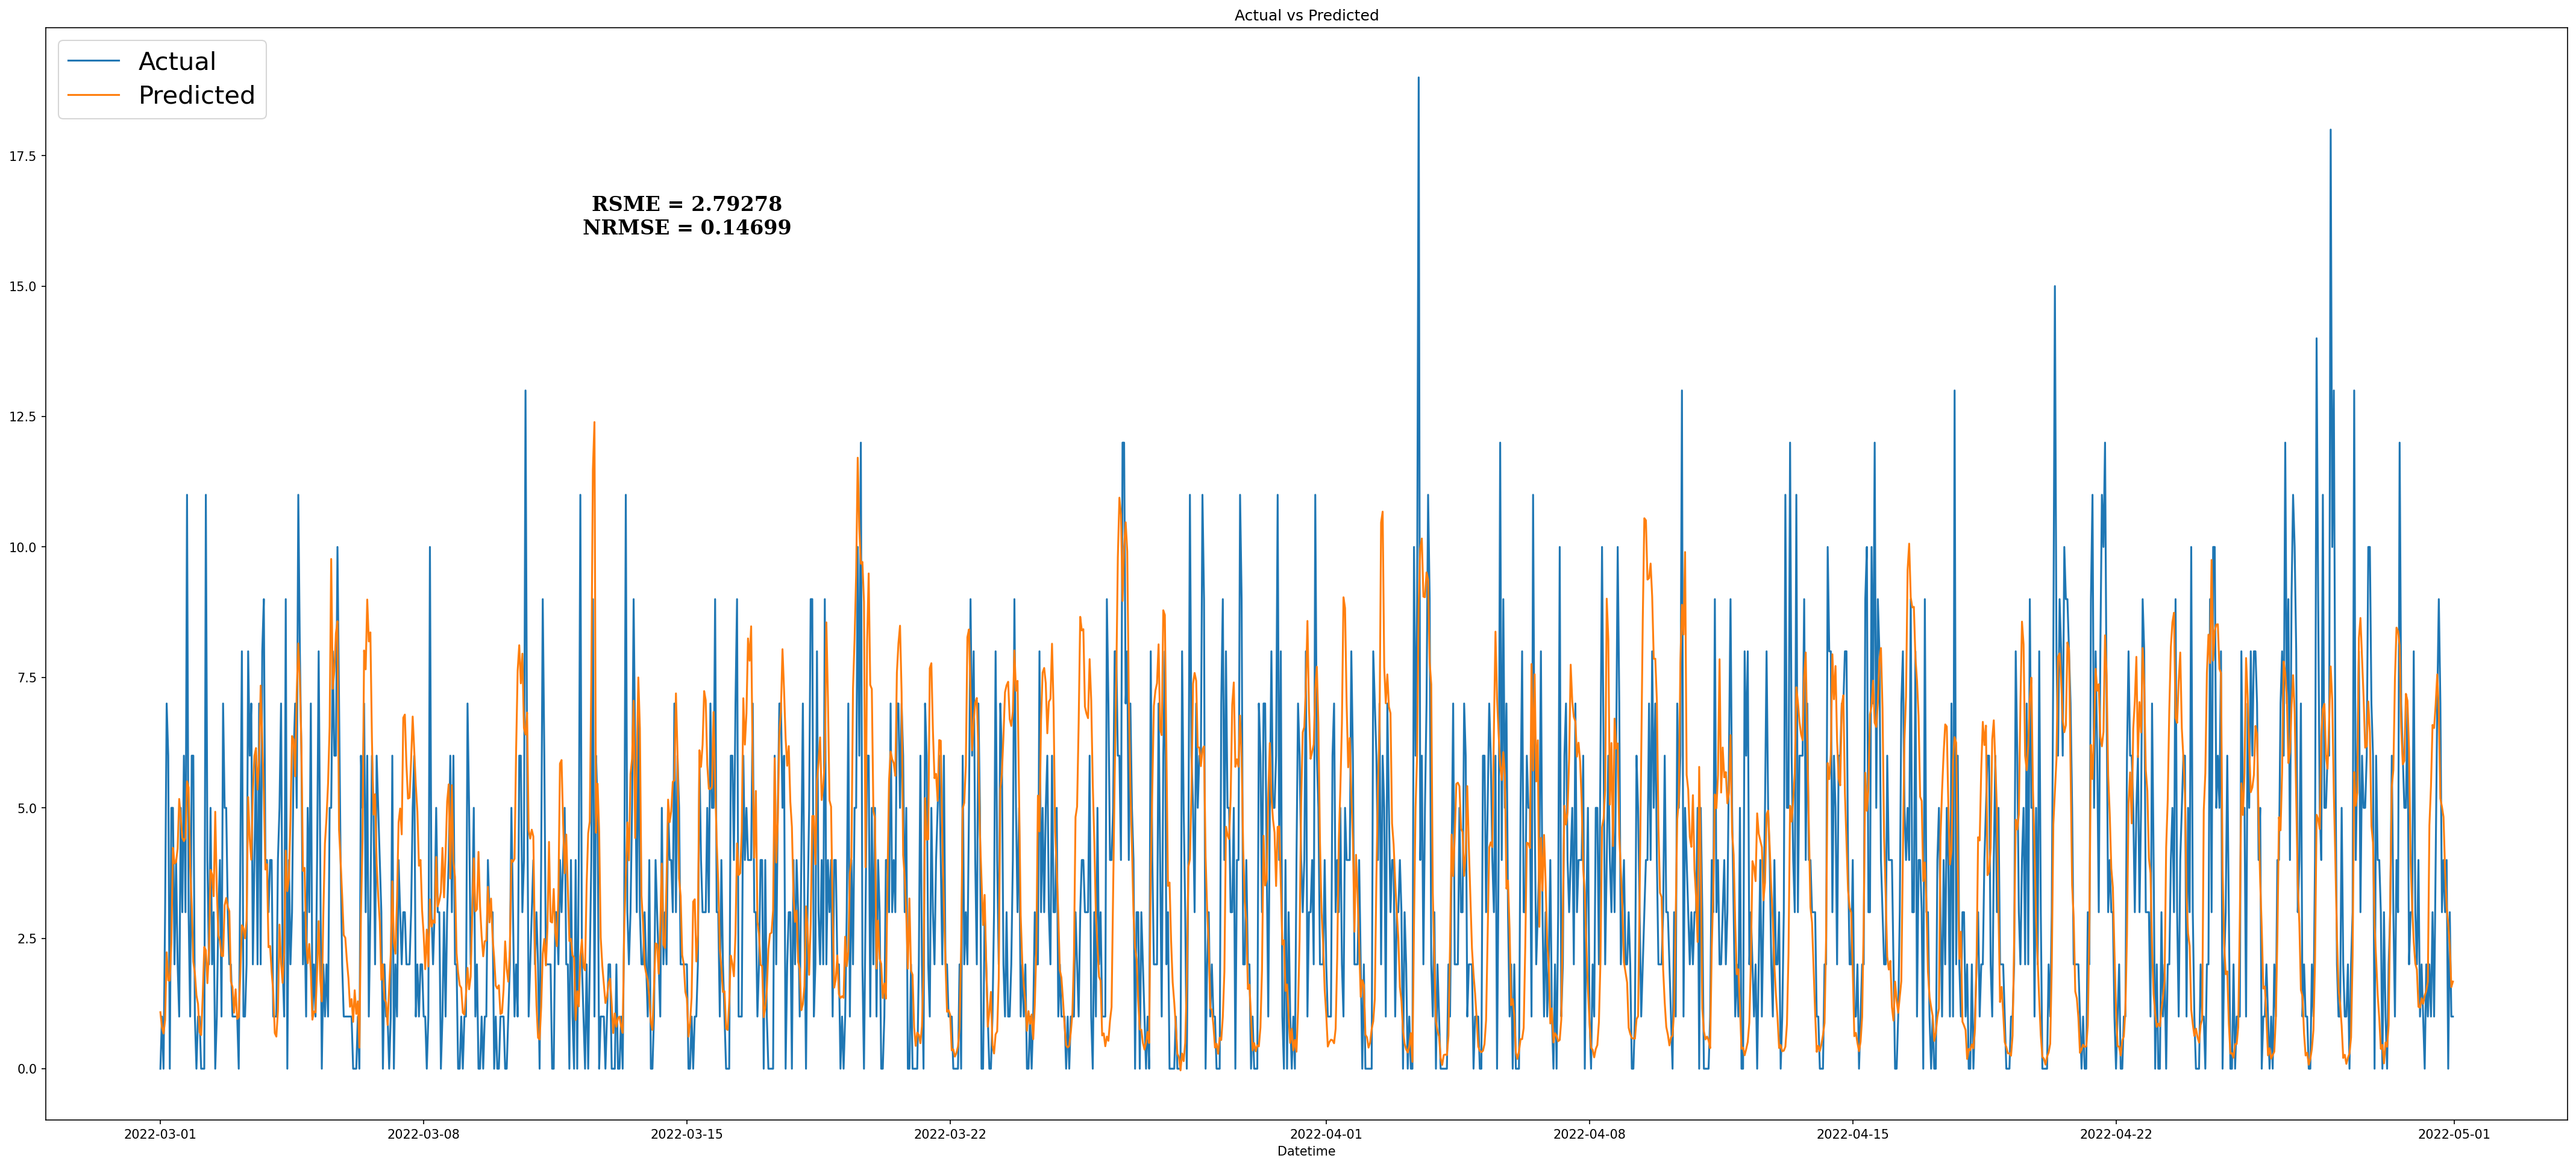

In [76]:
fig, ax = plt.subplots(figsize=(36, 16), dpi=150)

sns.lineplot(data=new_df, x='Period', y='Actual', ax=ax, ci=None)
sns.lineplot(data=new_df, x='Period', y='Predicted', ax=ax, ci=None)
ax.set(xlabel='Datetime', ylabel='', title='Actual vs Predicted')
plt.legend(title='', loc='upper left', labels=['Actual', 'Predicted'], fontsize=20, labelspacing=0.4)
plt.annotate('> 15% infected birds', xy=(12, 3), xytext=(10, 3),
             fontsize=10,fontweight='bold',fontfamily='serif',ha='center', color='#004D44')
annotate_text = f'RSME = {round(rsme_score,5)}\nNRMSE = {round(normalized_rsme_score,5)}'
plt.annotate(annotate_text, xy=(pd.to_datetime('2022-03-15'),16), xytext=(pd.to_datetime('2022-03-15'), 16), 
             fontsize=16,fontweight='bold',fontfamily='serif',ha='center')
plt.show()

## Daily rentals "mean"

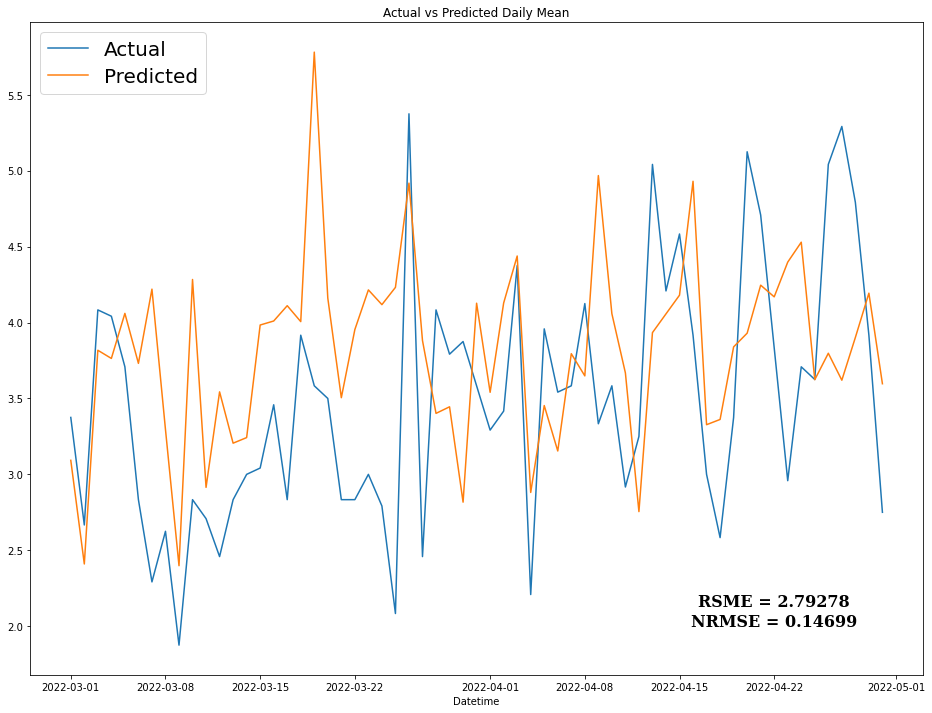

In [75]:
daily_meandf = new_df.groupby(new_df['Period'].dt.date).mean()
fig, ax = plt.subplots(figsize=(16, 12))
sns.lineplot(data=daily_meandf, x='Period', y='Actual', ax=ax, ci=None)
sns.lineplot(data=daily_meandf, x='Period', y='Predicted', ax=ax, ci=None)
ax.set(xlabel='Datetime', ylabel='', title='Actual vs Predicted Daily Mean')
plt.legend(title='', loc='upper left', labels=['Actual', 'Predicted'], fontsize=20, labelspacing=0.4)
annotate_text = f'RSME = {round(rsme_score,5)}\nNRMSE = {round(normalized_rsme_score,5)}'
plt.annotate(annotate_text, xy=(pd.to_datetime('2022-04-22'),2), xytext=(pd.to_datetime('2022-04-22'), 2), 
             fontsize=16,fontweight='bold',fontfamily='serif',ha='center')
plt.show()

## Daily rentals "total"

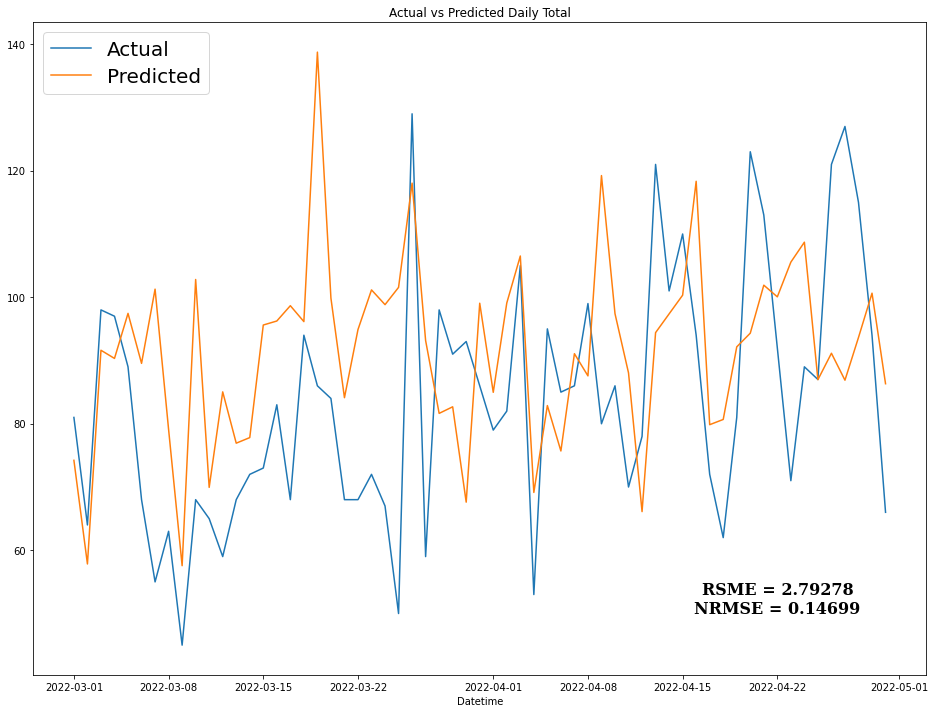

In [74]:
daily_sumdf = new_df.groupby(new_df['Period'].dt.date).sum()
fig, ax = plt.subplots(figsize=(16, 12))
sns.lineplot(data=daily_sumdf, x='Period', y='Actual', ax=ax, ci=None)
sns.lineplot(data=daily_sumdf, x='Period', y='Predicted', ax=ax, ci=None)
ax.set(xlabel='Datetime', ylabel='', title='Actual vs Predicted Daily Total')
plt.legend(title='', loc='upper left', labels=['Actual', 'Predicted'], fontsize=20, labelspacing=0.4)
annotate_text = f'RSME = {round(rsme_score,5)}\nNRMSE = {round(normalized_rsme_score,5)}'
plt.annotate(annotate_text, xy=(pd.to_datetime('2022-04-22'),50), xytext=(pd.to_datetime('2022-04-22'), 50), 
             fontsize=16,fontweight='bold',fontfamily='serif',ha='center')
plt.show()

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini